# The Battle of Neighborhoods

### Introduction/Business Problem 

New York City, the most populous city in the United States, one of the greatest metropolises over the world, is a dream place for gourmet to seek delicious cuisine. Its food culture includes an array of international cuisines influenced by the city's immigrant history. Central and Eastern European immigrants, especially Jewish immigrants from those regions, brought bagels, cheesecake, hot dogs, knishes, and delicatessens (or delis) to the city. Italian immigrants brought New York-style pizza and Italian cuisine into the city, while Jewish immigrants and Irish immigrants brought pastrami and corned beef, respectively. Chinese and other Asian restaurants, sandwich joints, trattorias, diners, and coffeehouses are ubiquitous throughout the city. Some 4,000 mobile food vendors licensed by the city, many immigrant-owned, have made Middle Eastern foods such as falafel and kebabs examples of modern New York street food. The city is home to "nearly one thousand of the finest and most diverse haute cuisine restaurants in the world," according to Michelin. As of 2019, there were 27,043 restaurants in the city, up from 24,865 in 2017.
    
As the figures tell, New York City attracts many to start their business in the food industry. Before they take action, they need to find out where they would open it? What would they consider when selecting a location? By exploring the regional characteristics of these restaurants, I hope to figure out whether the neighborhood of restaurants is an essential factor for the success of a restaurant with sound analysis.

As I mentioned above, there are hundreds of restaurants, and it is impractical to run an analysis for each type of restaurant. Based on the maximum total numbers among these restaurants, I choose Japanese Restaurant for the following report.

### Data Section

Data used in the analysis are listed below:

· Neighborhoods in New York City -- Wikipedia. I cleaned the data and reduced it to boroughs of NYC so that I can use it to find geological locations for further venue analysis.

· Using Geopy to get geological location by address name

· Using Foursquare API to get the most common venues of given Borough of New York City.

· Using Foursquare API to get the venues' record of given venues of New York City.

### Methodology

Neighborhoods using, geopy, FourSquare API & New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude.

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
import os

# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'T05H0TCFMOFQWWHD1OCUVX3T3ENXZJ4JNWD0SYDUXOTYSPS5'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='NLI0BMFSDHOVU0DAR0TZWBBE0KVFWSYWZITRX04QUEXEE55M' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function to get venue details like like count , rating , tip counts for a given venue id. to be used for ranking.

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'T05H0TCFMOFQWWHD1OCUVX3T3ENXZJ4JNWD0SYDUXOTYSPS5'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='NLI0BMFSDHOVU0DAR0TZWBBE0KVFWSYWZITRX04QUEXEE55M' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a funtion to get the New York city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [9]:
# get new york data
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

Based on the dataset, there are a total of 306 different Neighborhoods in New York to select from

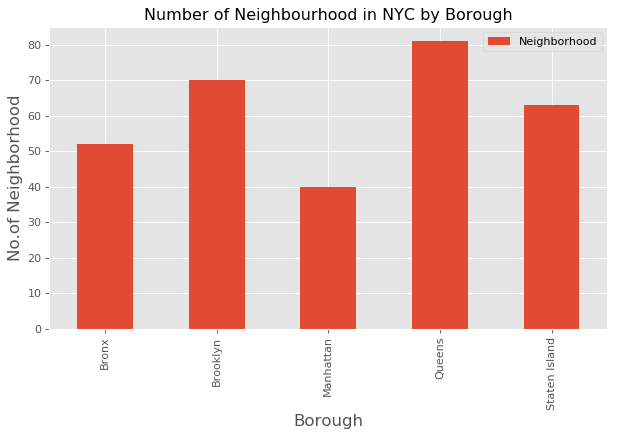

In [11]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

Based on the data, Queens is the most densely populated borough in New York City with 80 neighborhoods

In [12]:
# prepare neighborhood list that contains japanese restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:2
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:1
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

In [13]:
japanese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse


In [14]:
japanese_rest_ny.shape

(182, 4)

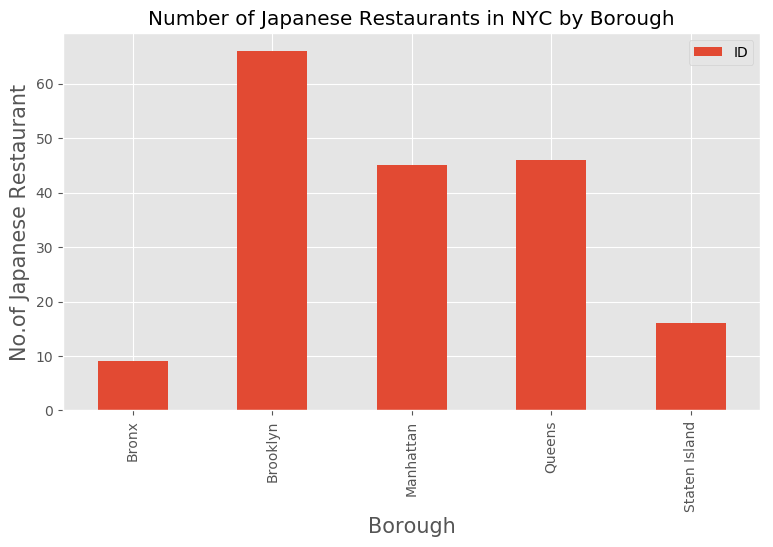

In [15]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Restaurant', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

It is noted that Brooklyn has the highest number of Japanese Restaurants.

In [16]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
79,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
80,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
81,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
82,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
83,Manhattan,Murray Hill,48c50c4bf964a520dc511fe3,Café Zaiya
118,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi
119,Queens,Murray Hill,5cf07afa66f3cd002c8b3ae6,Izakaya Mew


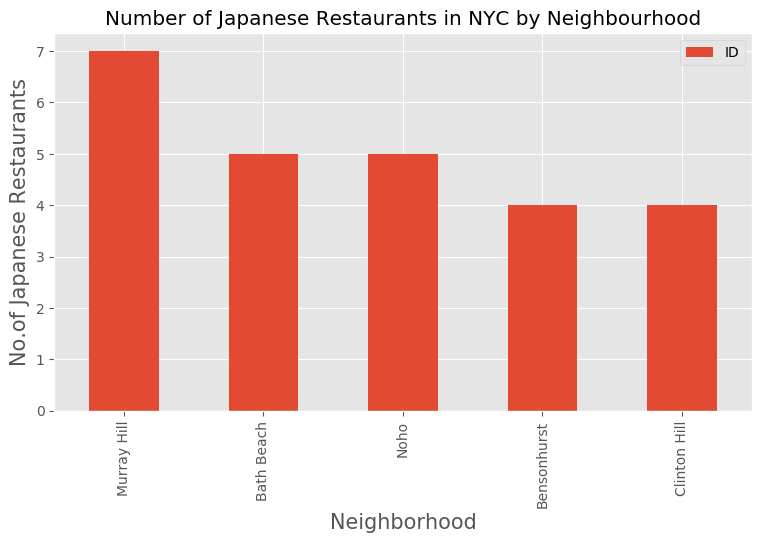

In [17]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Restaurants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Murray Hill in Manhattan has the most Japanese Resturants

In [18]:
# prepare neighborhood list that contains japanese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print(ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                      Name  Likes  Rating  Tips
0  503cfaffe4b066d39de5005a  Aoyu Japanese Restaurant     32     9.1    19
( 1 / 182 ) processed
                         ID             Name  Likes  Rating  Tips
0  4b0b311af964a520642e23e3  Palace of Japan     38     8.4    26
( 2 / 182 ) processed
                         ID                      Name  Likes  Rating  Tips
0  503cfaffe4b066d39de5005a  Aoyu Japanese Restaurant     32     9.1    19
( 3 / 182 ) processed
                         ID             Name  Likes  Rating  Tips
0  4b0b311af964a520642e23e3  Palace of Japan     38     8.4    26
( 4 / 182 ) processed
                         ID                                         Name  \
0  4dbdf3d790a02849cbd675be  Ohana Japanese Habachi Seafood & Steakhouse   

   Likes  Rating  Tips  
0     34     7.7    18  
( 5 / 182 ) processed
                         ID      Name  Likes  Rating  Tips
0  5d40d7a398a00a0008b4c8ca  Benihana      0     7.6     0
( 6 /

In [19]:
japanese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.1,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.4,26
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.1,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.4,26
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,34,7.7,18


In [20]:
japanese_rest_stats_ny.shape

(182, 7)

In [21]:
japanese_rest_ny.shape

(182, 4)

In [22]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny.csv', index=False)
japanese_rest_stats_ny_csv=pd.read_csv('japanese_rest_stats_ny.csv')
japanese_rest_stats_ny_csv.shape

(182, 7)

In [23]:
japanese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.1,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.4,26
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,9.1,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.4,26
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,34,7.7,18


In [24]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 7 columns):
Borough         182 non-null object
Neighborhood    182 non-null object
ID              182 non-null object
Name            182 non-null object
Likes           182 non-null object
Rating          182 non-null float64
Tips            182 non-null object
dtypes: float64(1), object(6)
memory usage: 10.0+ KB


In [25]:
japanese_rest_stats_ny['Likes']=japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips']=japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny['Rating']=japanese_rest_stats_ny['Rating'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 7 columns):
Borough         182 non-null object
Neighborhood    182 non-null object
ID              182 non-null object
Name            182 non-null object
Likes           182 non-null float64
Rating          182 non-null float64
Tips            182 non-null float64
dtypes: float64(3), object(4)
memory usage: 10.0+ KB


In [26]:
# Restaurants with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              4c7f0887fb74236a7727f9b9
Name                        Samurai Mama
Likes                                895
Rating                               8.8
Tips                                 244
Name: 27, dtype: object

In [27]:
# Restaurants with maximum Rating
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                   Riverdale
ID              503cfaffe4b066d39de5005a
Name            Aoyu Japanese Restaurant
Likes                                 32
Rating                               9.1
Tips                                  19
Name: 0, dtype: object

In [28]:
# Restaurants with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              4c7f0887fb74236a7727f9b9
Name                        Samurai Mama
Likes                                895
Rating                               8.8
Tips                                 244
Name: 27, dtype: object

In [29]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [30]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
20,Cobble Hill,9.10
82,Park Slope,8.85
91,Riverdale,8.75
59,Kingsbridge,8.75
95,Spuyten Duyvil,8.75
10,Brooklyn Heights,8.70
37,Fort Greene,8.70
108,Williamsburg,8.45
12,Bushwick,8.40
84,Prospect Heights,8.35


In [31]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [32]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,8.377778
1,Brooklyn,4.698485
2,Manhattan,0.000000
3,Queens,0.000000
4,Staten Island,0.000000


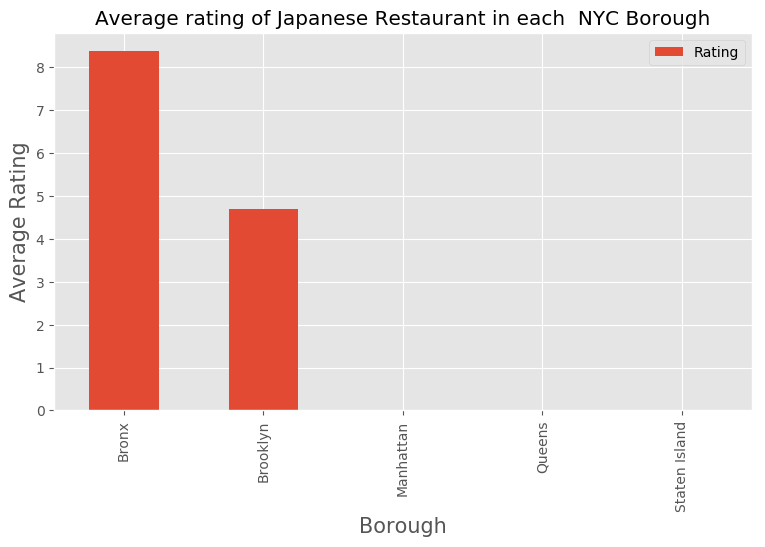

In [33]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Japanese Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Bronx has the highest average rating for Japanese Restaurants.

All the neighborhoods with average rating greater or equal 8.0 to be visualized on map

In [34]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [35]:
ny_neighborhood_stats

,Neighborhood,Average Rating
5,Bedford Stuyvesant,8.10
10,Brooklyn Heights,8.70
12,Bushwick,8.40
19,Clinton Hill,8.15
20,Cobble Hill,9.10
37,Fort Greene,8.70
57,Kensington,8.00
59,Kingsbridge,8.75
72,Marine Park,8.00
82,Park Slope,8.85


In [36]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [37]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [38]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
4,Brooklyn,Cobble Hill,40.687920,-73.998561,9.10
9,Brooklyn,Park Slope,40.672321,-73.977050,8.85
7,Bronx,Kingsbridge,40.881687,-73.902818,8.75
11,Bronx,Riverdale,40.890834,-73.912585,8.75
12,Bronx,Spuyten Duyvil,40.881395,-73.917190,8.75
1,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.70
5,Brooklyn,Fort Greene,40.688527,-73.972906,8.70
13,Brooklyn,Williamsburg,40.707144,-73.958115,8.45
2,Brooklyn,Bushwick,40.698116,-73.925258,8.40
10,Brooklyn,Prospect Heights,40.676822,-73.964859,8.35


In [39]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [40]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [41]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

Best neighbourhoods in New York that has highest average rating for Japanese Restaurants.

In [42]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Results:

1. Park Slope, Brooklyn Height, Fort Greene in Brooklyn are some of the best neighborhoods for Japanese cuisine.
2. Kingsbridge, Riverdale, Spuyten Duyvil in Bronx are some of the best neighborhoods for Japanese cusine.
3. Manhattan is the best place to stay if you prefer Japanese Cuisine.

### Conclusion:

Murray Hill in Manhanttan or Brooklyn Height in Brooklyn would be the best choice to start a restaurant given that:
    1. Brooklyn is the most populous county in the state, the second-most densely populated county in the United States.
    2. Manhattan is the most densely populated of New York City’s 5 boroughs,  it’s the heart of “the Big Apple.”
    3. Both neighborhoods have some top rated Japanese Restaurants.

### Discussion:
As a recommendation to those who plan to operate a restaurant, location selection is only one fundamental problem to think over. The analysis of this report assumes the type of restaurant is selected, for example, a Japanese Restaurant. It can not solve the problem of whether a type of restaurant is the most popular type and how many customers will visit every day. And as for location suggestion, it offers an opportunity analysis but lacks risk analysis, like the cost of the location and competition in that area.

Although in this report, it demonstrates the relations between location and ratings, but ratings might not reflect the operation status of the restaurant. A restaurant with a high rating could still be unprofitable, which is unsuccessful from a business perspective. So the suggestion is relatively narrow. To suggest more practical and profitable ideas, the relationship between customer reactions and financial performance should be evaluated.

With all these analyses done, the report finally becomes constructive for a restaurant owner in the real business world.